Name: Devrim ÇAVUŞOĞLU

Student Id: 2010023

In [80]:
"""
Imports and constants.
"""

from functools import wraps
from time import time
from typing import Tuple
from pathlib import Path

import numpy as np
import PIL.Image
from PIL import ImageDraw
from scipy.signal import convolve2d


PROJECT_ROOT = Path.cwd()
RSC_DIR = PROJECT_ROOT / "rsc"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
OUTPUT_DIR.mkdir(exist_ok=True)

In [69]:
"""
This part is devoted to utilities/helper functions that are usually
shared between all tasks. Mostly for IO and visualization.
"""


def timing(f):
    """
    A decorator to be used for computing runtime of functions.
    Taken from: https://stackoverflow.com/a/27737385
    """
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r | took: %2.4f sec' % (f.__name__, te-ts))
        return result
    return wrap


def pillow2numpy(a: PIL.Image.Image) -> np.ndarray:
    return np.array(a)


def numpy2pillow(a: np.ndarray) -> PIL.Image.Image:
    return PIL.Image.fromarray(a)
    

def get_top10(img: np.ndarray, scores: np.ndarray):
    if img.shape != scores.shape:
        raise ValueError(f"Image and scores shapes do not match. Image: {img.shape} | Scores: {scores.shape}")
    
    corners = np.zeros_like(img, dtype=np.uint8)
    ind_x, ind_y = np.unravel_index(np.argsort(scores, axis=None), scores.shape)
    corners[ind_x[-10:], ind_y[-10:]] = 1
    return corners


def load_image(filename: str, grayscale: bool = True) -> np.ndarray:
    img = PIL.Image.open(RSC_DIR / filename)
    if grayscale:
        img = img.convert('L')
    return pillow2numpy(img)


def draw_img_corners(pil_img: PIL.Image.Image, corners: np.ndarray):
    iy, ix = np.where(corners > 0)
    draw = ImageDraw.Draw(pil_img)
    for x, y in zip(ix, iy):
        draw.ellipse([x-1,y-1,x+1,y+1], outline="red", width=1)
    return pil_img


def image_grid(imgs, rows, cols):
    """
    Taken from https://stackoverflow.com/a/65583584/7871601
    """
    assert len(imgs) == rows*cols
    

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        # Pad each image to create a grid line by each cell to 
        # distinguish the corners on neighbouring edges.
        np_img = pillow2numpy(img)
         
        pil_img = numpy2pillow(np_img)
        grid.paste(numpy2pillow(np_img), box=(i%cols*w, i//cols*h))
    return grid


def draw_corners_on_fixtures(func: callable, *args, save_as: str = None, **kwargs):
    # Pad each image to create a grid line by each cell to 
    # distinguish the corners on neighbouring edges.
    # Also padding is needed for visualizing annotations,
    # pil silently skips out-of-bounds circles.
    rgb_padding = ((2, 2), (2, 2), (0, 0))
    
    pil_imgs = []
    for img_path in RSC_DIR.glob("*"):
        img = PIL.Image.open(img_path)
        np_img = pillow2numpy(img.convert("L"))
        corners = func(np_img, *args, **kwargs)
        corners = np.pad(corners, 2)
        np_img = np.pad(pillow2numpy(img), rgb_padding, constant_values=255)
        img = numpy2pillow(np_img)
        pil_img = draw_img_corners(img, corners)
        pil_imgs.append(pil_img)
    grid_img = image_grid(pil_imgs, 3, 2)
    if save_as:
        grid_img.save(OUTPUT_DIR / save_as)
    return grid_img

In [87]:
"""
This part is devoted to functions shared between at least 2 tasks 
that implement a pre/post-processing algorithm regarding corner detection.
"""


def local_non_maximum_supression(scores: np.ndarray, window_size: int = 1) -> np.ndarray:
    """
    Runs NMS over the array `a` with a (square) window.

    Args:
        a:
        window_size: Window size, 1 by default.
    """
    m, n = scores.shape
    offset = max(window_size//2, 1)
    scores = np.pad(scores, offset)  # zero pad for convenience
    for i in range(offset, m+offset):
        for j in range(offset, n+offset):
            patch = scores[i - offset:i + offset+1, j - offset:j + offset+1]
            patch_max = patch.max()
            ix, iy = np.where(patch == patch.max())  # idx are 0,1,2 due to locality
            scores[i - offset:i + offset+1, j - offset:j + offset+1] = 0
            scores[i + ix[0] - offset, j + iy[0] - offset] = patch_max
    return scores[offset:-offset, offset:-offset]  # unpad


def sobel(image: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Applies Sobel Operator and returns gradients.
    """
    GAUSSIAN_1D = np.array([1, 2, 1])
    DIFF_1D = np.array([1, 0, -1])
    
    kernel_x = GAUSSIAN_1D.reshape(-1, 1) @ DIFF_1D.reshape(1, -1)
    kernel_y = DIFF_1D.reshape(-1, 1) @ GAUSSIAN_1D.reshape(1, -1)
    gx = convolve2d(image, kernel_x, mode="same")
    gy = convolve2d(image, kernel_y, mode="same")
    return gx, gy

### Task 1: Naive Formula + Uniform Weighting

func:'naive_harris_vectorized' | took: 0.0160 sec
func:'naive_harris_vectorized' | took: 0.0150 sec
func:'naive_harris_vectorized' | took: 0.0130 sec
func:'naive_harris_vectorized' | took: 0.0130 sec
func:'naive_harris_vectorized' | took: 0.0150 sec
func:'naive_harris_vectorized' | took: 0.0160 sec


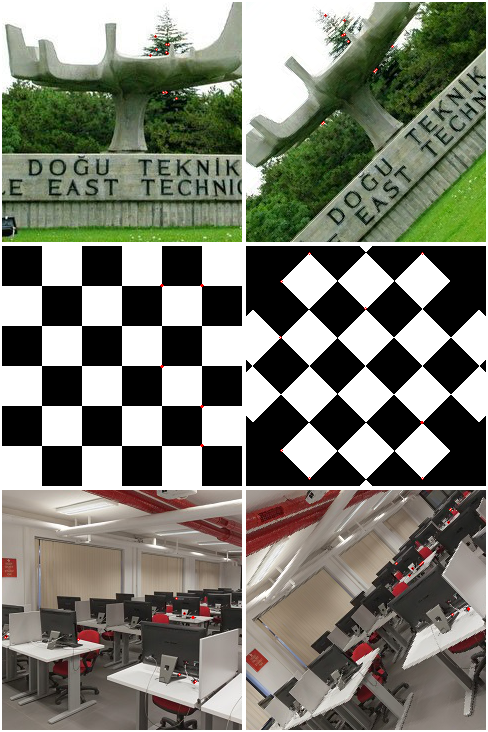

In [70]:
## Write your code here

def get_shift_filter(x, y):
    k = np.zeros((3,3))
    k[y+1, x+1] = 1
    return k


def compute_vectorized_ssd(img: np.ndarray):
    ssd = 0
    for u in range(-1, 2):
        for v in range(-1, 2):
            if (u, v) == (0, 0):
                continue
            shifted_img = convolve2d(img, get_shift_filter(u, v), mode="same")
            ssd += np.square(shifted_img - img)
    return ssd.astype(int)


def compute_ssd(img: np.ndarray, pos: Tuple[int, int]):
    x, y = pos    
    ssd = 0
    for u in range(-1, 2):
        for v in range(-1, 2):
            if (u, v) == (0, 0):
                continue
            # Need to cast higher bit integer types to encounter overflow
            ssd += np.square(img[x+u,y+v].astype(np.int32) - img[x,y].astype(np.int32))
    return ssd.astype(int)



@timing
def naive_harris(img: np.ndarray):
    """
    Implements naive harris method by looping over all pixels.
    """
    if img.ndim != 2:
        raise ValueError("Image must be a given in grayscale as 2d array.")
    
    m, n = img.shape
    ssds = np.zeros_like(img, dtype=float)
    img = np.pad(img, 1)  # zero pad for convenience
    for x in range(1, m+1):
        for y in range(1, n+1):
            ssds[x-1, y-1] = compute_ssd(img, (x,y))
    
    img = img[1:-1, 1:-1]  # unpad
    return get_top10(img, ssds)


@timing
def naive_harris_vectorized(img: np.ndarray, filter_boundary: bool = False):
    """
    Implements naive Harris method by utilizing convolution on image. Unlike 
    `naive_harris()`, this function shifts image in 8 directions by convolution, 
    and then use the resulting shifted images to compute pixel SSDs in a 
    vectorized way.
    
    The implementation computes `M_i = (X - X'_i)^2` where i is 8 (unit) 
    directions, M_i is the elementwise squared difference matrix, X is the original
    image, and X_i is the shifted version of X in direction i. Shifting is carried 
    out by 2d (3,3) convolution filter.
    
    Args:
        img: 
        filter_boundary: The corners found at pixels on image boundaries are 
            suppressed if True.  
        
    """
    if img.ndim != 2:
        raise ValueError("Image must be a given in grayscale as 2d array.")
    
    ssds = compute_vectorized_ssd(img)
    if filter_boundary:
        m,n = ssds.shape
        ssds[0, :] = 0
        ssds[:, 0] = 0
        ssds[m-1, :] = 0
        ssds[:, n-1] = 0
    corners = get_top10(img, ssds)
    return corners


def test_equal():
    print("Testing if vectorized and naive version outputs are equal.")
    img = load_image("agac.png")
    ssd_vectorized = naive_harris_vectorized(img)
    ssd_naive = naive_harris(img)
    assert np.array_equal(ssd_vectorized, ssd_naive)
    print("Test is successful!")
    print("=" * 60)


# test_equal()
draw_corners_on_fixtures(naive_harris_vectorized, filter_boundary=True, save_as="task_1.png")

In [34]:
## This part is for discussion


### Task2: Naive Formula + Uniform Weighting + Non-Maximum Suppression

func:'naive_harris_nms' | took: 0.5685 sec
func:'naive_harris_nms' | took: 0.5745 sec
func:'naive_harris_nms' | took: 0.5755 sec
func:'naive_harris_nms' | took: 0.5735 sec
func:'naive_harris_nms' | took: 0.5885 sec
func:'naive_harris_nms' | took: 0.5765 sec


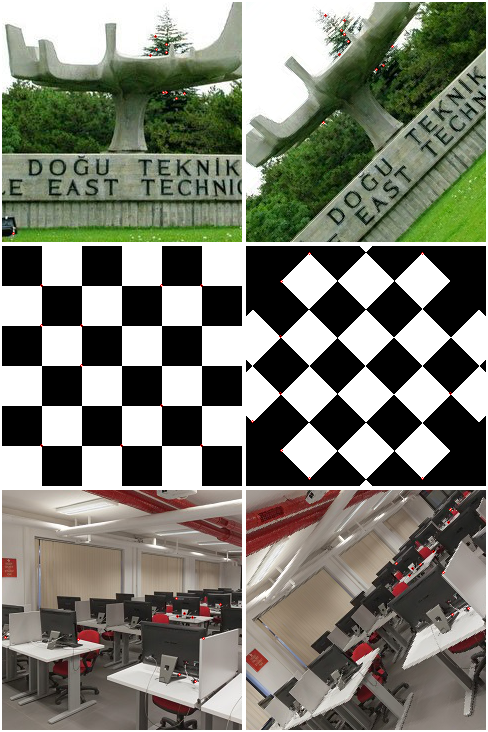

In [78]:
## Write your code here


@timing
def naive_harris_nms(img: np.ndarray, filter_boundary: bool = False):
    """
    Implements vectorized naive Harris + NMS. 
    """
    if img.ndim != 2:
        raise ValueError("Image must be a given in grayscale as 2d array.")
    
    ssds = compute_vectorized_ssd(img)
    if filter_boundary:
        m,n = ssds.shape
        ssds[0, :] = 0
        ssds[:, 0] = 0
        ssds[m-1, :] = 0
        ssds[:, n-1] = 0
    ssds = local_non_maximum_supression(ssds, 1)
    corners = get_top10(img, ssds)
    return corners


draw_corners_on_fixtures(naive_harris_nms, filter_boundary=True, save_as="task_2.png")

In [50]:
## This part is for discussion



### Task3: Taylor's Approximation + Uniform Weighting + Non-Maximum Suppression

func:'harris_taylor_approximation' | took: 2.0819 sec
func:'harris_taylor_approximation' | took: 2.0959 sec
func:'harris_taylor_approximation' | took: 2.1039 sec
func:'harris_taylor_approximation' | took: 2.0959 sec
func:'harris_taylor_approximation' | took: 2.1179 sec
func:'harris_taylor_approximation' | took: 2.0990 sec


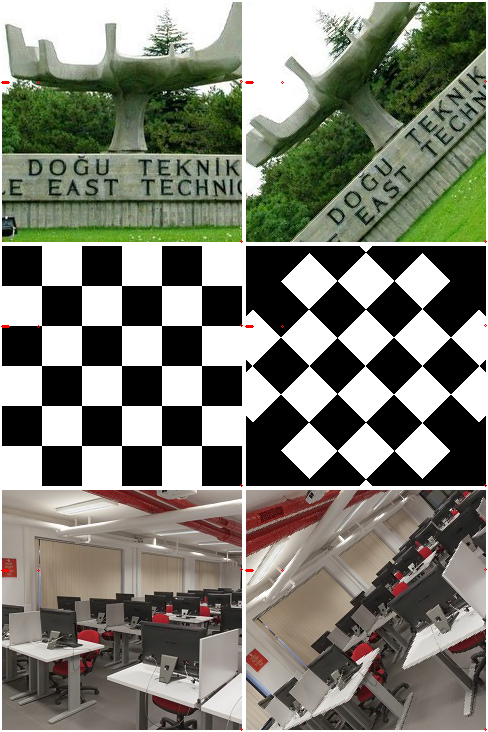

In [113]:
## Write your code here


def compute_ssd_taylor(G: np.ndarray, pos: Tuple[int, int]):
    x, y = pos
    ssd = 0
    H = G[:,:,x-1:x+2, y-1:y+2].sum(axis=2).sum(axis=2)
    t = []
    for u in range(-1, 2):
        for v in range(-1, 2):
            if (u, v) == (0, 0):
                continue
            t.append(np.array([[u, v]]))
    t = np.vstack(t)  # (8,2)
    ssd = t @ H @ t.T
    return ssd.sum().item()


@timing
def harris_taylor_approximation(img: np.ndarray, filter_boundary: bool = False):
    """
    Implements vectorized naive Harris + NMS. 
    """
    if img.ndim != 2:
        raise ValueError("Image must be a given in grayscale as 2d array.")
    
    m, n = img.shape
    G_padding = ((0,0), (0, 0), (1, 1), (1, 1))
    
    gx, gy = sobel(img)
    gj = gx * gy  # gj refers to 'joint'
    G = np.array([[gx ** 2, gj], [gj, gy ** 2]])  # (2,2,m,n)
    
    G = np.pad(G, G_padding)
    ssds = np.zeros_like(img)
    for x in range(1, m+1):
        for y in range(1, n+1):
            ssds[x-1, y-1] = compute_ssd_taylor(G, (x, y))
            
    if filter_boundary:
        m,n = ssds.shape
        ssds[0, :] = 0
        ssds[:, 0] = 0
        ssds[m-1, :] = 0
        ssds[:, n-1] = 0
    ssds = local_non_maximum_supression(ssds, 1)
    corners = get_top10(img, ssds)
    return corners


draw_corners_on_fixtures(harris_taylor_approximation, filter_boundary=True, save_as="task_3.png")

In [ ]:
## This part is for discussion



### Task 4: Smaller Eigenvalue as corner score + Uniform Weighting + Non-Maximum Suppression

In [ ]:
## Write your code here


In [ ]:
## This part is for discussion



### Task 5: R function as corner score + Uniform Weighting + Non-Maximum Suppression

In [ ]:
## Write your code here


In [ ]:
## This part is for discussion



### Task 6: R function with fast windowing based on fitering + Uniform Weighting + Non-Maximum Suppression

In [ ]:
## Write your code here


In [ ]:
## This part is for discussion



### Task 7: R function with fast windowing based on fitering + Gaussian Weighting + Non-Maximum Suppression

In [ ]:
## Write your code here


In [ ]:
## This part is for discussion

